In [2]:
import os
from multiprocessing import Pool, cpu_count

import numpy as np
import pandas as pd

from random import sample

import matplotlib.pyplot as plt
%matplotlib inline

## Keras
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, GlobalAveragePooling2D, Activation, Reshape
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.optimizers import Adam, SGD, Adadelta, Nadam
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import Sequence
from keras import backend as K

from keras.applications.densenet import DenseNet121 as base_network1
from sklearn.model_selection import StratifiedKFold
from skimage.transform import resize
import math
from pathlib import Path
import pydicom
import itertools

## MultiGPU Code
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))
import keras.utils.training_utils
from keras.utils import multi_gpu_model
gdev = keras.utils.training_utils._get_available_devices()
gdev_count = 0
for i, n in enumerate(gdev):
    if 'device:GPU' in n:
        gdev_count+=1
if gdev_count > 0:
    print('Found {} GPUs, will attempt to use all of them.'.format(gdev_count))
else:
    gdev_count=1
    print('Did not find any GPUs, this will be SLOW!')

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 8 GPUs, will attempt to use all of them.


# Load Data

In [3]:
data = pd.read_csv('/media/share/data/thyroid/subinfo/cleaned.csv')
print(data.head())
print(data.shape)

         ID  Cancer
0  22404884       0
1  26152292       1
2  20823486       0
3    780001       1
4  22215276       0
(818, 2)


In [4]:
img_rows = 256
img_cols = 256
session_name = 'thyroid_'

In [5]:
n_folds = 5
skf = StratifiedKFold(n_folds, shuffle=True, random_state=np.random)
for train_index, test_index in skf.split(np.arange(len(data)), data['Cancer']):
    break

# Build Datasets

In [28]:
def img_preproc(img):
    
    from skimage.color import rgb2gray
    from skimage.filters import threshold_otsu
    from skimage.morphology import closing, square
    from skimage.measure import label, regionprops
    from skimage.segmentation import clear_border
    from scipy.ndimage.morphology import binary_fill_holes
    from skimage.transform import resize
    
    img_rows = 384
    img_cols = 384
    
#     im = rgb2gray(img)
#     thresh = threshold_otsu(im)
#     bw = closing(im > thresh, square(3))
#     cleared = clear_border(bw)
    
#     # mask
#     step1 = im * ~cleared
#     step2 = threshold_otsu(step1)
#     step3 = closing(step1 > step2, square(5))
#     step4 = binary_fill_holes(step3)
    
#     # search largest area
#     label_img = label(step4)
    
#     bbarea = []
#     for region in regionprops(label_img):
#         bbarea.append(region.area)
    
#     minr, minc, maxr, maxc = regionprops(label_img)[bbarea.index(np.max(bbarea))].bbox
    
    # remain the original h/w propotion
    x_pad = (np.array(img.shape).max() - img.shape[0])//2
    y_pad = (np.array(img.shape).max() - img.shape[1])//2
    tmp_img = np.pad(img,((x_pad,x_pad),(y_pad,y_pad),(0, 0)),'constant')
    crop_img = resize(tmp_img, [img_rows, img_cols], mode='constant')
    
    return crop_img

def build_dataset(x):
    images = []
    labels = []
    for p in Path('/media/share/data/thyroid/thyroid_' + ('cancer' if int(x[1].Cancer) else 'healthy')).glob(str(x[1].ID) + '*/*.dcm'):
        dcm = pydicom.dcmread(str(p), force=True)
        # Some dicom files have multiple images...
        if len(dcm.pixel_array.shape) > 3:
            for pa in dcm.pixel_array:
                if dcm.PlanarConfiguration > 1:
                    images += [img_preproc(np.transpose(pa, (2,0,1)).reshape(dcm.Rows, dcm.Columns, dcm.SamplesPerPixel))]
                else:
                    images += [img_preproc(pa)]
                labels += [x[1].Cancer]
        # Single images
        else:
            if dcm.PlanarConfiguration > 1:
                images += [img_preproc(np.transpose(dcm.pixel_array, (2,0,1)).reshape(dcm.Rows, dcm.Columns, dcm.SamplesPerPixel))]
            else:
                images += [img_preproc(dcm.pixel_array)]
            labels += [x[1].Cancer]
    return images, labels

In [29]:
from keras.utils import to_categorical

with Pool(cpu_count()) as pool:
    print('Importing Training Set')
    train_imgs, train_labels = zip(*pool.map(build_dataset, data.iloc[train_index].iterrows()))
    train_imgs = list(itertools.chain(*train_imgs))
    train_labels = list(itertools.chain(*train_labels))
    print('Importing Validation Set')
    val_imgs, val_labels = zip(*pool.map(build_dataset, data.iloc[test_index].iterrows()))
    val_imgs = list(itertools.chain(*val_imgs))
    val_labels = list(itertools.chain(*val_labels))

Importing Training Set
Importing Validation Set


In [30]:
# Check training and validation sizes
print('Training Images:', len(train_imgs))
print('Validation Images:', len(val_imgs))

Training Images: 8353
Validation Images: 2276


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


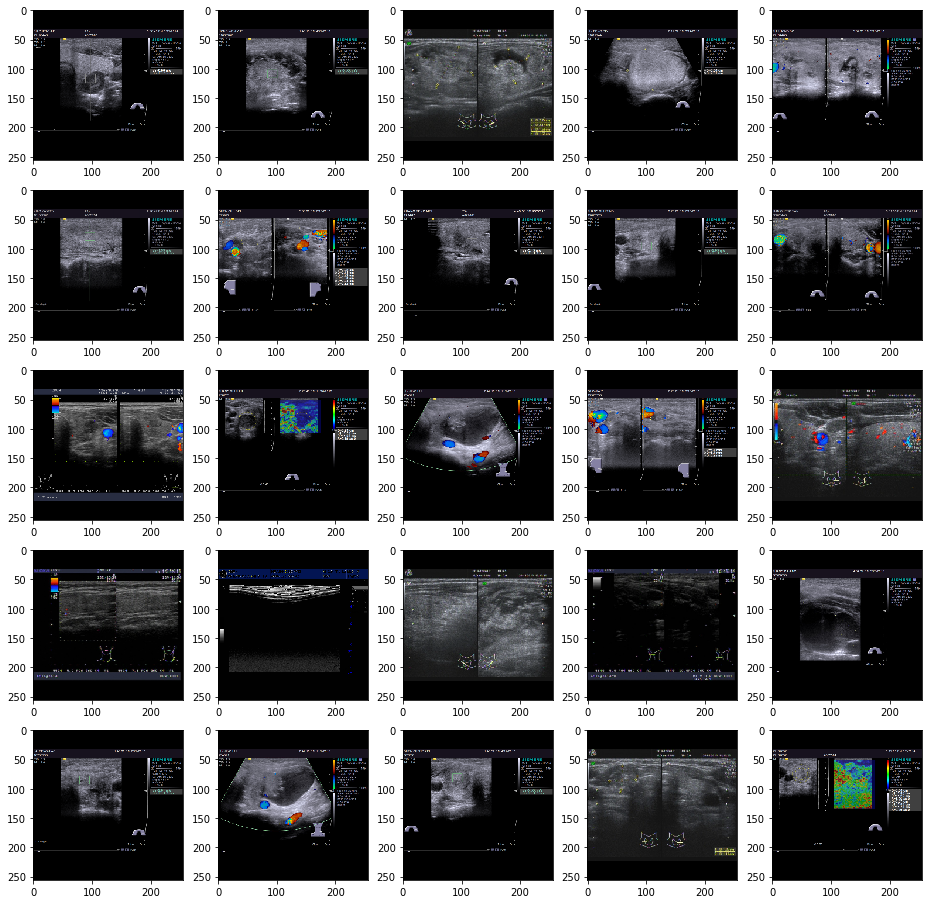

In [31]:
# Show some sample images @ken
from random import sample

fig = plt.figure(figsize=(16, 16))
for i, n in enumerate(sample(list(train_imgs), 25)):
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(n)

# Training

In [33]:
from keras.utils import to_categorical

def gen(x, y, b):
    while True:
        x_out, y_out = zip(*sample(list(zip(x, y)), b))
        yield np.asarray(x_out), to_categorical(y_out)

# Build Neural Network

### Dense net 121

In [38]:
# dense 121
K.clear_session()

base_model = base_network1(include_top=False, pooling=None, input_shape=(img_rows, img_cols, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(2, activation='softmax')(x)
smodel = Model(base_model.input, x)

# MultiGPU Code
smodel.summary()
if gdev_count > 1:
    model = multi_gpu_model(smodel, gdev_count)
    model.summary()
else:
    model = smodel

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_4 (

In [40]:
model_checkpoint = ModelCheckpoint(session_name+'den121_acc.hdf5',
                                   monitor='val_acc', save_best_only=True, save_weights_only=True)
model_checkpoint2 = ModelCheckpoint(session_name+'den121_loss.hdf5',
                                    monitor='val_loss', save_best_only=True, save_weights_only=True)
# model_reducelr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=8)
model_earlystop = EarlyStopping(patience=64, monitor='val_acc')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
batch_size = 24 * gdev_count
train_history = model.fit_generator(gen(train_imgs, train_labels, batch_size),
                                    steps_per_epoch=8, epochs=2**7,
                                    validation_data=gen(val_imgs, val_labels, batch_size),
                                    validation_steps=4,
                                    verbose=2, callbacks=[model_checkpoint, model_checkpoint2])

Epoch 1/128
 - 57s - loss: 1.1702 - acc: 0.5859 - val_loss: 1.5742 - val_acc: 0.6849
Epoch 2/128
 - 11s - loss: 0.5800 - acc: 0.6699 - val_loss: 1.4920 - val_acc: 0.6237
Epoch 3/128
 - 11s - loss: 0.5371 - acc: 0.6934 - val_loss: 1.0199 - val_acc: 0.7096
Epoch 4/128
 - 11s - loss: 0.4844 - acc: 0.7435 - val_loss: 3.1644 - val_acc: 0.6758
Epoch 5/128
 - 11s - loss: 0.4574 - acc: 0.7702 - val_loss: 1.8079 - val_acc: 0.3880
Epoch 6/128
 - 11s - loss: 0.4065 - acc: 0.7988 - val_loss: 3.1435 - val_acc: 0.6849
Epoch 7/128
 - 11s - loss: 0.3157 - acc: 0.8438 - val_loss: 2.6937 - val_acc: 0.7370
Epoch 8/128
 - 11s - loss: 0.3127 - acc: 0.8496 - val_loss: 1.1438 - val_acc: 0.4727
Epoch 9/128
 - 11s - loss: 0.2988 - acc: 0.8639 - val_loss: 1.7667 - val_acc: 0.7305
Epoch 10/128
 - 11s - loss: 0.2284 - acc: 0.8861 - val_loss: 1.9841 - val_acc: 0.6693
Epoch 11/128
 - 11s - loss: 0.1988 - acc: 0.9062 - val_loss: 1.8651 - val_acc: 0.4141
Epoch 12/128
 - 11s - loss: 0.1863 - acc: 0.9193 - val_loss: 3.

Epoch 97/128
 - 12s - loss: 0.0293 - acc: 0.9896 - val_loss: 2.9968 - val_acc: 0.4661
Epoch 98/128
 - 11s - loss: 0.0227 - acc: 0.9915 - val_loss: 3.2110 - val_acc: 0.4609
Epoch 99/128
 - 11s - loss: 0.0369 - acc: 0.9883 - val_loss: 2.8633 - val_acc: 0.4115
Epoch 100/128
 - 11s - loss: 0.0403 - acc: 0.9844 - val_loss: 2.5864 - val_acc: 0.6602
Epoch 101/128
 - 11s - loss: 0.0502 - acc: 0.9824 - val_loss: 2.5981 - val_acc: 0.4466
Epoch 102/128
 - 11s - loss: 0.0528 - acc: 0.9824 - val_loss: 2.8420 - val_acc: 0.4974
Epoch 103/128
 - 11s - loss: 0.0371 - acc: 0.9863 - val_loss: 3.4089 - val_acc: 0.3659
Epoch 104/128
 - 12s - loss: 0.0388 - acc: 0.9863 - val_loss: 2.6491 - val_acc: 0.6862
Epoch 105/128
 - 11s - loss: 0.0235 - acc: 0.9909 - val_loss: 3.7873 - val_acc: 0.4219
Epoch 106/128
 - 11s - loss: 0.0197 - acc: 0.9954 - val_loss: 3.0175 - val_acc: 0.5234
Epoch 107/128
 - 11s - loss: 0.0415 - acc: 0.9863 - val_loss: 3.5770 - val_acc: 0.3867
Epoch 108/128
 - 11s - loss: 0.0153 - acc: 0.9

### Dense net 201

In [41]:
# dense 201
from keras.applications.densenet import DenseNet201 as base_network2
K.clear_session()

base_model = base_network2(include_top=False, pooling=None, input_shape=(img_rows,img_cols,3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(2, activation='softmax')(x)
smodel = Model(base_model.input, x)

# MultiGPU Code
smodel.summary()
if gdev_count > 1:
    model = multi_gpu_model(smodel, gdev_count)
    model.summary()
else:
    model = smodel

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_4 (

In [42]:
model_checkpoint = ModelCheckpoint(session_name+'den201_acc.hdf5',
                                   monitor='val_acc', save_best_only=True, save_weights_only=True)
model_checkpoint2 = ModelCheckpoint(session_name+'den201_loss.hdf5',
                                    monitor='val_loss', save_best_only=True, save_weights_only=True)

# model_reducelr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=8)
# model_earlystop = EarlyStopping(patience=64, monitor='val_acc')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
batch_size = 24 * gdev_count
train_history = model.fit_generator(gen(train_imgs, train_labels, batch_size),
                                    steps_per_epoch=8, epochs=2**7,
                                    validation_data=gen(val_imgs, val_labels, batch_size),
                                    validation_steps=4,
                                    verbose=2, callbacks=[model_checkpoint, model_checkpoint2])

Epoch 1/128
 - 102s - loss: 1.4080 - acc: 0.5677 - val_loss: 1.3156 - val_acc: 0.6719
Epoch 2/128
 - 16s - loss: 0.6362 - acc: 0.6693 - val_loss: 1.4631 - val_acc: 0.6836
Epoch 3/128
 - 16s - loss: 0.5510 - acc: 0.7018 - val_loss: 1.0388 - val_acc: 0.3789
Epoch 4/128
 - 16s - loss: 0.5072 - acc: 0.7298 - val_loss: 0.7154 - val_acc: 0.6484
Epoch 5/128
 - 16s - loss: 0.4968 - acc: 0.7376 - val_loss: 0.6796 - val_acc: 0.7448
Epoch 6/128
 - 16s - loss: 0.4613 - acc: 0.7572 - val_loss: 1.1539 - val_acc: 0.3685
Epoch 7/128
 - 16s - loss: 0.4182 - acc: 0.7943 - val_loss: 0.6868 - val_acc: 0.6875
Epoch 8/128
 - 16s - loss: 0.4237 - acc: 0.7949 - val_loss: 0.8436 - val_acc: 0.5911
Epoch 9/128
 - 16s - loss: 0.3962 - acc: 0.7982 - val_loss: 2.8272 - val_acc: 0.6914
Epoch 10/128
 - 16s - loss: 0.3408 - acc: 0.8333 - val_loss: 1.6074 - val_acc: 0.6979
Epoch 11/128
 - 16s - loss: 0.3170 - acc: 0.8581 - val_loss: 2.4309 - val_acc: 0.4870
Epoch 12/128
 - 16s - loss: 0.2582 - acc: 0.8861 - val_loss: 1

Epoch 97/128
 - 16s - loss: 0.0178 - acc: 0.9928 - val_loss: 2.6780 - val_acc: 0.6055
Epoch 98/128
 - 16s - loss: 0.0250 - acc: 0.9935 - val_loss: 2.4145 - val_acc: 0.7240
Epoch 99/128
 - 16s - loss: 0.0301 - acc: 0.9889 - val_loss: 5.7991 - val_acc: 0.3750
Epoch 100/128
 - 16s - loss: 0.0251 - acc: 0.9902 - val_loss: 2.5529 - val_acc: 0.5638
Epoch 101/128
 - 16s - loss: 0.0138 - acc: 0.9954 - val_loss: 3.5086 - val_acc: 0.4102
Epoch 102/128
 - 16s - loss: 0.0331 - acc: 0.9902 - val_loss: 2.5845 - val_acc: 0.7227
Epoch 103/128
 - 16s - loss: 0.0371 - acc: 0.9850 - val_loss: 3.5051 - val_acc: 0.6914
Epoch 104/128
 - 16s - loss: 0.0990 - acc: 0.9655 - val_loss: 3.7734 - val_acc: 0.4896
Epoch 105/128
 - 16s - loss: 0.0629 - acc: 0.9772 - val_loss: 2.6476 - val_acc: 0.6523
Epoch 106/128
 - 16s - loss: 0.0537 - acc: 0.9818 - val_loss: 5.7651 - val_acc: 0.3268
Epoch 107/128
 - 16s - loss: 0.0422 - acc: 0.9850 - val_loss: 4.7990 - val_acc: 0.4674
Epoch 108/128
 - 16s - loss: 0.0298 - acc: 0.9

### Inception-resnet-v2

In [43]:
# inception-resnet-v2
from keras.applications.inception_resnet_v2 import InceptionResNetV2 as base_network3
K.clear_session()

base_model = base_network3(include_top=False, pooling=None, input_shape=(img_rows,img_cols,3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1, activation='sigmoid')(x)
smodel = Model(base_model.input, x)

# MultiGPU Code
smodel.summary()
if gdev_count > 1:
    model = multi_gpu_model(smodel, gdev_count)
    model.summary()
else:
    model = smodel

219062272/219055592 [==============================] - 519s 2us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 127, 127, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 127, 127, 32) 0           batch_normalization_1[0][0]      
________________________________________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_4 (

In [44]:
model_checkpoint = ModelCheckpoint(session_name+'inrv2_acc.hdf5',
                                   monitor='val_acc', save_best_only=True, save_weights_only=True)
model_checkpoint2 = ModelCheckpoint(session_name+'inrv2_loss.hdf5',
                                    monitor='val_loss', save_best_only=True, save_weights_only=True)
# model_reducelr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=8)
# model_earlystop = EarlyStopping(patience=64, monitor='val_acc')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
batch_size = 24 * gdev_count
train_history = model.fit_generator(gen(train_imgs, train_labels, batch_size),
                                    steps_per_epoch=128, epochs=2**7,
                                    validation_data=gen(val_imgs, val_labels, batch_size),
                                    validation_steps=128,
                                    verbose=2, callbacks=[model_checkpoint, model_checkpoint2])

Epoch 1/128


ValueError: Error when checking target: expected dense_1 to have shape (1,) but got array with shape (2,)

### Resnet 50

In [ ]:
# resnet 50
from keras.applications.resnet50 import ResNet50 as base_network4

K.clear_session()

base_model = base_network4(include_top=False, pooling=None, input_shape=(img_rows,img_cols,3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1, activation='sigmoid')(x)
smodel = Model(base_model.input, x)

# MultiGPU Code
smodel.summary()
if gdev_count > 1:
    model = multi_gpu_model(smodel, gdev_count)
    model.summary()
else:
    model = smodel

In [ ]:
model_checkpoint = ModelCheckpoint(session_name+'res50_acc.hdf5',
                                   monitor='val_acc', save_best_only=True, save_weights_only=True)
model_checkpoint2 = ModelCheckpoint(session_name+'res50_loss.hdf5',
                                    monitor='val_loss', save_best_only=True, save_weights_only=True)
# model_reducelr = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=8)
# model_earlystop = EarlyStopping(patience=64, monitor='val_acc')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
batch_size = 24 * gdev_count
train_history = model.fit_generator(gen(train_imgs, train_labels, batch_size),
                                    steps_per_epoch=128, epochs=2**7,
                                    validation_data=gen(val_imgs, val_labels, batch_size),
                                    validation_steps=128,
                                    verbose=2, callbacks=[model_checkpoint, model_checkpoint2])

# Check Training History

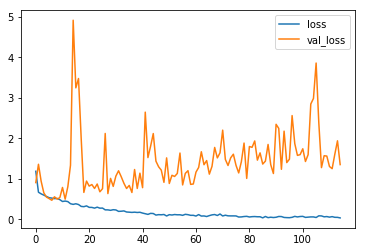

In [15]:
plt.figure()
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.legend(['loss', 'val_loss'])

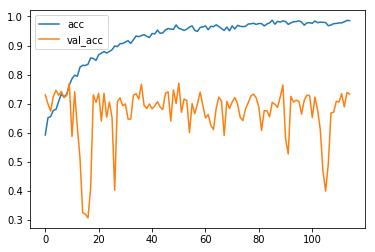

In [16]:
plt.figure()
plt.plot(train_history.history['acc'])
plt.plot(train_history.history['val_acc'])
plt.legend(['acc', 'val_acc'])

# Model Evaluation